In [1]:
""" setup """
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use(['classic'])

from redbaron import redbaron
redbaron.ipython_behavior = False

from pyha.simulation.simulation_interface import assert_sim_match

In [2]:
def dc_rem(inputs, alen, cascn=1):
    group_delay = int((alen-1)/2*cascn)
    
    taps = [1 / alen] * alen
    
    ret = inputs
    
    for _ in range(cascn):
        ret = np.convolve(ret, taps, mode='full')[:-alen + 1]
    
    return inputs[:-group_delay] - ret[group_delay:]

In [4]:
def estimate_frequency_phase_response(input, output):
    sum_h = None
    H1 = np.array([0 + 0 * 1j] * len(input[0]))
    for i, o in zip(input, output):
        I = fft(i)
        O = fft(o)
        new_h = I * O / I ** 2
        new_h /= len(input)  # average
        H1 += new_h

#     H1 = fftshift(H1)
    magnitude = 20 * np.log10(abs(H1))
    phase = np.angle(H1) * 180 / np.pi
    
    out_len = len(magnitude) // 2
    
    return magnitude[:out_len], phase[:out_len]

# Freqz

<IPython.core.display.Javascript object>


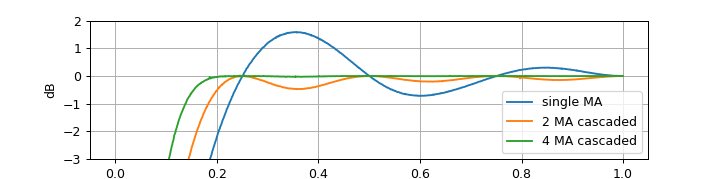

In [5]:
# https://se.mathworks.com/matlabcentral/newsreader/view_thread/154499
from scipy.fftpack import fft, fftshift


def get_response(mavg_len, mavg_casc):
    l = 2**11
    u = [np.random.uniform(-1, 1, l) for _ in range(l)]
    y = [dc_rem(x, mavg_len, mavg_casc)[:l] for x in u]


    u = [x[:len(y[0])] for x in u]
    mag, _ = estimate_frequency_phase_response(u, y)
    return mag


plt.figure(figsize=(8, 2))
y = get_response(8, 1)
f = np.array(range(len(y))) / len(y)
plt.plot(f, y, label='single MA')

y = get_response(8, 2)
f = np.array(range(len(y))) / len(y)
plt.plot(f, y, label='2 MA cascaded')


y = get_response(8, 4)
f = np.array(range(len(y))) / len(y)
plt.plot(f, y, label='4 MA cascaded')

plt.xlabel("Normalized frequency")
plt.ylabel("dB")
plt.grid()
plt.legend()
plt.ylim(-3, 2)

plt.savefig('img/dc_single_freqz.png', bbox_inches='tight')

plt.show()